# House Prices - Advanced Regression Techniques
*Predict sales prices and practice feature engineering, RFs, and gradient boosting*

In [904]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetics for the plots
sns.set(style="whitegrid", palette="muted")

RANDOM_STATE = 101

# pd.set_option('display.precision', 2)

### Data collection

In [905]:
df_train = pd.read_csv("./data/train.csv")
pd.concat([df_train.head(2), df_train.tail(2)])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


### EDA

In [906]:
df_train.info()
# 1460 rows
# 81 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [907]:
def show_missing_data(df):
    """
    Display number and percentage of columns with any missing value
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (
        ((df.isnull().sum() / df.isnull().count()) * 100)
        .sort_values(ascending=False)
        .round(2)
    )
    missing_data = pd.concat([total, percent], axis=1, keys=["# missing", "% missing"])
    print(missing_data[missing_data["# missing"] > 0])


show_missing_data(df_train)

              # missing  % missing
PoolQC             1453      99.52
MiscFeature        1406      96.30
Alley              1369      93.77
Fence              1179      80.75
MasVnrType          872      59.73
FireplaceQu         690      47.26
LotFrontage         259      17.74
GarageYrBlt          81       5.55
GarageCond           81       5.55
GarageType           81       5.55
GarageFinish         81       5.55
GarageQual           81       5.55
BsmtFinType2         38       2.60
BsmtExposure         38       2.60
BsmtQual             37       2.53
BsmtCond             37       2.53
BsmtFinType1         37       2.53
MasVnrArea            8       0.55
Electrical            1       0.07


- `PoolQC`, `MiscFeature`, `Alley`, `Fence` can be discarded (>80% missing records)
- `MasVnrType`, `FireplaceQu` with 60% & 47% missing records. Are they relevant? can be infered?
- `LotFrontage` with 18% missing records.  Relevant/can be infered?
- There are 12 features with missing values than need handling

In [908]:
df_train.groupby("MasVnrType")["SalePrice"].mean().sort_values(ascending=False)

MasVnrType
Stone      265583.625000
BrkFace    204691.871910
BrkCmn     146318.066667
Name: SalePrice, dtype: float64

In [909]:
df_train.groupby("FireplaceQu")["SalePrice"].mean().sort_values(ascending=False)

FireplaceQu
Ex    337712.500000
Gd    226351.415789
TA    205723.488818
Fa    167298.484848
Po    129764.150000
Name: SalePrice, dtype: float64

In [910]:
df_train.groupby("LotFrontage")["SalePrice"].mean().sort_values(ascending=True)

LotFrontage
153.0     52500.000000
45.0      80500.000000
21.0      94278.260870
33.0     113000.000000
50.0     122563.719298
             ...      
107.0    342947.571429
150.0    375000.000000
118.0    415000.000000
104.0    473333.333333
160.0    745000.000000
Name: SalePrice, Length: 110, dtype: float64

In [911]:
df_train.groupby("GarageYrBlt")["SalePrice"].mean().sort_values(ascending=False)

GarageYrBlt
2010.0    337874.666667
2008.0    306569.034483
2009.0    306111.000000
2006.0    262001.338983
1994.0    258100.000000
              ...      
1924.0    116166.666667
1927.0    115000.000000
1920.0    109992.857143
1952.0    101331.000000
1938.0     89850.000000
Name: SalePrice, Length: 97, dtype: float64

In [912]:
# Correlation of GarageYrBlt with YearBuilt and YearRemodAdd
df_train[
    [
        "GarageYrBlt",
        "YearBuilt",
        "YearRemodAdd",
    ]
].corr().loc["GarageYrBlt", ["YearBuilt", "YearRemodAdd"]]

YearBuilt       0.825667
YearRemodAdd    0.642277
Name: GarageYrBlt, dtype: float64

☝🏻 Careful -> skewed distribution of price

- In statistical analysis, a non-skewed distribution is typically a normal distribution, which resembles a bell curve when graphed. This means it's symmetric, with most of the observations clustering around the central peak and the probabilities for values further away from the mean tapering off equally in both directions.

- If we don't apply a log transformation to SalePrice when it's skewed, your model may not perform as well, especially if it assumes that the residuals (errors) are normally distributed, as many linear models do. Applying a log transformation can help stabilize the variance across the data range and make the data conform more closely to the assumptions of parametric statistical tests, leading to more reliable statistical inference and potentially better model performance. If a log transformation is applied, the distribution should look more like a normal distribution, with fewer outliers and a more symmetric shape.

- When should log **NOT** be applied to the target variable?
  - The distribution of the target variable is already close to normal. Log transformation in such cases might lead to a worse fit.
  - The model you're using is robust to non-normality, like tree-based models (e.g., decision trees, random forests).
  - The range of the target variable is narrow with low variance, so the proportional differences are minimal.
  - You have a binary or categorical target variable. In classification problems, log transformation is not applicable.
  - The relationship between predictors and the target is linear, and there are no signs of heteroscedasticity (uneven spread of residuals).

<Figure size 1000x1000 with 0 Axes>

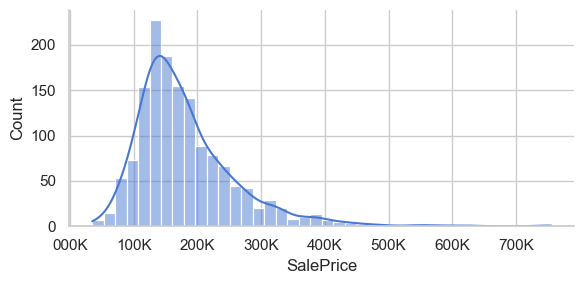

In [913]:
plt.figure(figsize=(10, 10))
sns.displot(df_train["SalePrice"] / 100000, bins=40, kde=True, height=3, aspect=2)
plt.xticks(ticks=[i for i in range(0, 8)], labels=[f"{i}00K" for i in range(0, 8)])
plt.show()

### Data cleaning & Preprocessing

In [914]:
# remove unnecessary fields
df_train.drop(["PoolQC", "MiscFeature", "Alley", "Fence"], axis=1, inplace=True)

# TODO: perhaps can be infered?
df_train.drop(["MasVnrType", "FireplaceQu", "LotFrontage"], axis=1, inplace=True)

# fill null `GarageYrBlt` using `YearBuilt` (numerical ft.)
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(df_train["YearBuilt"])

# fill null `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond` (categorical ft.)
garage_columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
df_train[garage_columns] = df_train[garage_columns].fillna("NoGarage")

In [915]:
show_missing_data(df_train)
# careful, still records with BsmtFinType2 or BsmtExposure null but the others not

              # missing  % missing
BsmtFinType2         38       2.60
BsmtExposure         38       2.60
BsmtFinType1         37       2.53
BsmtQual             37       2.53
BsmtCond             37       2.53
MasVnrArea            8       0.55
Electrical            1       0.07


In [916]:
basement_columns = [
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
]
condition = (df_train["BsmtFinType2"].isnull()) & (df_train["BsmtFinType1"].notnull())
df_train[condition][["Id"] + basement_columns]

,Id,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,333,Gd,TA,No,GLQ,NaN


In [917]:
df_train[df_train["BsmtFinType1"] == "GLQ"]["BsmtFinType2"].value_counts()

BsmtFinType2
Unf    392
LwQ     10
Rec      9
ALQ      4
BLQ      2
Name: count, dtype: int64

In [918]:
df_train.loc[df_train["Id"] == 333, "BsmtFinType2"] = "Unf"

In [919]:
condition = (df_train["BsmtExposure"].isnull()) & (df_train["BsmtFinType1"].notnull())
df_train[condition][["Id"] + basement_columns]

,Id,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
948,949,Gd,TA,NaN,Unf,Unf


In [920]:
df_train[df_train["BsmtFinType1"] == "Unf"]["BsmtExposure"].value_counts()

BsmtExposure
No    345
Av     46
Mn     27
Gd     11
Name: count, dtype: int64

In [921]:
df_train.loc[df_train["Id"] == 949, "BsmtExposure"] = "No"

In [922]:
show_missing_data(df_train)

              # missing  % missing
BsmtFinType1         37       2.53
BsmtFinType2         37       2.53
BsmtQual             37       2.53
BsmtCond             37       2.53
BsmtExposure         37       2.53
MasVnrArea            8       0.55
Electrical            1       0.07


In [923]:
# set value 'NoGarage' to all related garage fields with NaN values
indices = df_train[df_train["BsmtFinType2"].isnull()].index
df_train.loc[indices, basement_columns] = "NoGarage"

In [924]:
# fill null `MasVnrArea` with 0
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)

In [925]:
df_train["Electrical"].value_counts()

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

In [926]:
# fill null `Electrical` with most common value, which is 'SBrkr'
df_train["Electrical"] = df_train["Electrical"].fillna("SBrkr")

In [927]:
show_missing_data(df_train)

Empty DataFrame
Columns: [# missing, % missing]
Index: []


In [928]:
df_train.drop("Id", axis=1, inplace=True)

### Feature Engineering

In [929]:
# TODO

### Encoding categorical data

In [930]:
# List of columns to encode
columns_to_encode = df_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()
encoded_df_train = pd.get_dummies(df_train, columns=columns_to_encode, drop_first=True)

### Split dataset into Train/Test data

In [931]:
from sklearn.model_selection import train_test_split

X = encoded_df_train.drop("SalePrice", axis=1)
y = encoded_df_train["SalePrice"]

# Applying log transformation
y_log = np.log1p(encoded_df_train["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_STATE
)

### Regression Models

In [932]:
from xgboost import XGBRegressor


def fit_xgb_regressor(
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=1,
    n_estimators=100,
    objective="reg:squarederror",
    reg_alpha=0,
    scale_pos_weight=1,
    subsample=1,
):
    xgb = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective=objective,
        nthread=-1,
        scale_pos_weight=scale_pos_weight,
        seed=RANDOM_STATE,
        reg_alpha=reg_alpha,
    )
    xgb.fit(X_train, y_train)
    return xgb

In [933]:
# from xgboost import XGBRegressor

# regressor = XGBRegressor(
#     learning_rate=0.01,
#     n_estimators=3460,
#     max_depth=3,
#     min_child_weight=0,
#     gamma=0,
#     subsample=0.7,
#     colsample_bytree=0.7,
#     objective="reg:squarederror",
#     nthread=-1,
#     scale_pos_weight=1,
#     seed=27,
#     reg_alpha=0.00006,
# )

# regressor.fit(X_train, y_train)

### Fit Models

In [934]:
xgb = fit_xgb_regressor()

### Evaluation Functions

In [935]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_models(regressors, cv=10):
    results = []
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    for regressor in regressors:
        y_pred = regressor.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_cv = np.sqrt(
            -cross_val_score(
                regressor, X, y_log, scoring="neg_mean_squared_error", cv=kfolds
            )
        )
        results.append(
            {
                "Model": type(regressor).__name__,
                "MAE": mae,
                "MSE": mse,
                "RMSE": rmse,
                "RMSEcv": rmse_cv.mean(),
                "R^2": r2,
            }
        )
    sorted_results = sorted(results, key=lambda x: x["RMSE"], reverse=True)
    print(f"{'Model':<25} {'RMSEcv':<8} {'RMSE':<8} {'MAE':<8} {'MSE':<8} {'R^2':<8}")
    print("-" * 66)
    for result in sorted_results:
        metrics = f"{result['RMSEcv']:<8.2f} {result['RMSE']:<8.2f} "
        metrics += f"{result['MAE']:<8.2f} {result['MSE']:<8.2f} {result['R^2']:<8.2f}"
        print(f"{result['Model']:<25} {metrics}")

In [936]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_learning_curve(
    estimator,
    X= X,
    y = y_log,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    fig_size=(6, 4),
):
    plt.figure(figsize=fig_size)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=n_jobs,
        train_sizes=train_sizes,
    )

    # Take the negative of the scores because 'neg_mean_squared_error' is used
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

    sns.lineplot(x=train_sizes, y=train_scores_mean, label="Training score")
    sns.lineplot(x=train_sizes, y=test_scores_mean, label="Cross-validation score")

    plt.title(f"Learning Curve (RMSE) - {type(estimator).__name__}")
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

In [937]:
from sklearn.model_selection import GridSearchCV


def evaluate_model_grid_search_cv(
    regressor,
    X_train,
    y_train,
    params,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
):
    grid_search = GridSearchCV(
        estimator=regressor, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs
    )
    grid_search.fit(X=X_train, y=y_train)
    best_score = np.sqrt(-grid_search.best_score_)
    best_params = grid_search.best_params_
    print(f"Model: {type(regressor).__name__}")
    print(f" - Best RMSE: {best_score}")
    print(f" - Best params: {best_params}")

### Evaluate Models

In [938]:
models = [xgb]
evaluate_models(models, 2)

Model                     RMSEcv   RMSE     MAE      MSE      R^2     
------------------------------------------------------------------
XGBRegressor              0.15     0.16     0.11     0.03     0.85    


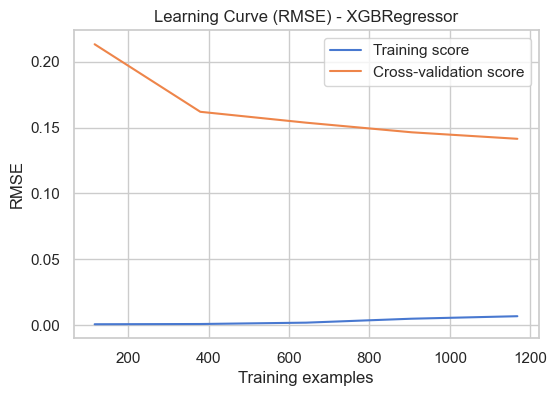

In [939]:
plot_learning_curve(xgb)

### Tune Models

In [940]:
params = {
    "colsample_bytree": [0.7],
    "gamma": [0],
    "learning_rate": [0.01, 0.05],
    "max_depth": [2, 3],
    "min_child_weight": [0],
    "n_estimators": [2500, 3460],
    "objective": ["reg:squarederror"],
    "reg_alpha": [0.00006],
    "scale_pos_weight": [1],
    "subsample": [0.7, 0.8],
}

evaluate_model_grid_search_cv(xgb, X_train, y_train, params, 5)

Model: XGBRegressor
 - Best RMSE: 0.12283198829061004
 - Best params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 3460, 'objective': 'reg:squarederror', 'reg_alpha': 6e-05, 'scale_pos_weight': 1, 'subsample': 0.7}


In [941]:
# xgb = fit_xgb_regressor(
#     0.01, 3460, 3, 0, 0, 0.7, 0.7, "reg:squarederror", 1, 0.00006
# )  # rmse: 0.12
xgb = fit_xgb_regressor(
    colsample_bytree=0.7,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=0,
    n_estimators=3460,
    objective="reg:squarederror",
    reg_alpha=0.00006,
    scale_pos_weight=1,
    subsample=0.7,
)

In [942]:
models = [xgb]
evaluate_models(models, 2)

Model                     RMSEcv   RMSE     MAE      MSE      R^2     
------------------------------------------------------------------
XGBRegressor              0.12     0.13     0.08     0.02     0.90    


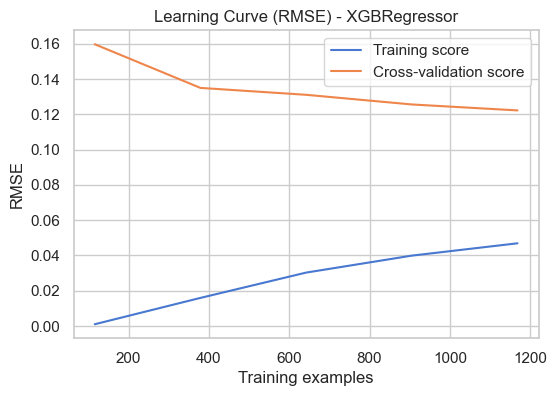

In [943]:
plot_learning_curve(xgb)